# 根据一份花卉数据集训练一个神经网络用于图像分类

导入所需模块

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import json
import torch
import torch.nn.functional as F

from torch import nn,optim
from collections import OrderedDict
from torch.autograd import Variable
from torchvision import datasets,transforms,models
from PIL import Image

## 加载数据

在此项目中，使用 `torchvision` 加载数据。数据集分成了三部分：训练集、验证集和测试集。对于训练集，我对数据进行了变换，例如随机缩放、剪裁和翻转。这样有助于网络泛化，并带来更好的效果。还将输入数据的大小调整为 224x224 像素，因为预训练的网络需要这样

而验证集和测试集是用于衡量模型对尚未见过的数据的预测效果。所以是不需要进行任何缩放或旋转变换，只需要将图像剪裁到合适的大小就可以了

对于所有三个数据集进行标准化。其中均值为 `[0.485, 0.456, 0.406]`，标准差为 `[0.229, 0.224, 0.225]`。这样会使得每个颜色通道的值位于 -1 到 1 之间，而不是 0 到 1 之间。

In [2]:
train_dir = 'flowers/train'
valid_dir = 'flowers/valid'
test_dir = 'flowers/test'""

In [3]:
#转换训练数据
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                            [0.229,0.224,0.225])])
#转换验证数据
valid_transforms = transforms.Compose([transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                            [0.229,0.224,0.225])])
#转换测试数据
test_transforms = transforms.Compose([transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])

#使用ImageFolder读取数据
train_dataset = datasets.ImageFolder(train_dir,transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir,transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir,transform=test_transforms)

#批量获取数据
trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset,batch_size=64,shuffle=True)

### 标签映射
加载类别标签到类别名称的映射。文件 `cat_to_name.json` 中可以找到对应的映射

In [4]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# 构建和训练分类器

* 加载预训练的网络
* 使用 ReLU 激活函数并重新定义新的未训练前馈网络作为分类器
* 损失函数是NLLLoss，优化器是Adam

加载预训练模型

In [5]:
#加载预训练模型
model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 90175170.47it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

重新定义分类器

In [6]:
for param in model.parameters():
    param.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
                          ('fc1',nn.Linear(25088,4096)),
                          ('relu1',nn.ReLU()),
                          ('dropout1',nn.Dropout(p=0.5)),
                          ('fc2',nn.Linear(4096,1000)),
                          ('relu2',nn.ReLU()),
                          ('dropout2',nn.Dropout()),
                          ('fc3',nn.Linear(1000,102)),
                          ('output',nn.LogSoftmax(dim=1))
                          ]))

model.classifier = classifier

定义损失函数和优化器

In [7]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.001)

定义训练函数和验证函数

In [8]:
#定义训练过程
def train(model, trainloader, validloader, criterion, optimizer, epochs = 3, 
          log_interval = 20, device = 'cuda'):
    steps = 0
    running_loss = 0
    model.train()
    model.to('cuda')
    for e in range(epochs):
        for images, labels in trainloader:
            steps += 1
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % log_interval == 0: 
                #计算损失要在验证模式下
                model.eval()
                with torch.no_grad():
                    valid_loss, valid_accuracy = validate(model, validloader, criterion)
                    print("Epoch: {}/{}.. ".format(e + 1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss / log_interval),
                          "Valid Loss: {:.3f}.. ".format(valid_loss / len(validloader)),
                          "Valid Accuracy: {:.3f}".format(valid_accuracy / len(validloader)))
                    running_loss = 0
                    running_accu = 0
                    #重新开始训练
                    model.train()
#定义验证过程
def validate(model, validloader, criterion, device = 'cuda'):
    loss = 0
    accuracy = 0
    for images, labels in validloader:
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        loss += criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return loss, accuracy


train(model,trainloader,validloader,criterion,optimizer)

Epoch: 1/3..  Training Loss: 5.271..  Valid Loss: 4.137..  Valid Accuracy: 0.091
Epoch: 1/3..  Training Loss: 3.871..  Valid Loss: 3.156..  Valid Accuracy: 0.334
Epoch: 1/3..  Training Loss: 3.155..  Valid Loss: 2.345..  Valid Accuracy: 0.434
Epoch: 1/3..  Training Loss: 2.610..  Valid Loss: 1.917..  Valid Accuracy: 0.522
Epoch: 1/3..  Training Loss: 2.370..  Valid Loss: 1.682..  Valid Accuracy: 0.581
Epoch: 2/3..  Training Loss: 1.997..  Valid Loss: 1.536..  Valid Accuracy: 0.624
Epoch: 2/3..  Training Loss: 1.855..  Valid Loss: 1.350..  Valid Accuracy: 0.631
Epoch: 2/3..  Training Loss: 1.732..  Valid Loss: 1.199..  Valid Accuracy: 0.675
Epoch: 2/3..  Training Loss: 1.698..  Valid Loss: 1.150..  Valid Accuracy: 0.694
Epoch: 2/3..  Training Loss: 1.728..  Valid Loss: 1.121..  Valid Accuracy: 0.706
Epoch: 3/3..  Training Loss: 1.524..  Valid Loss: 1.164..  Valid Accuracy: 0.704
Epoch: 3/3..  Training Loss: 1.434..  Valid Loss: 1.078..  Valid Accuracy: 0.721
Epoch: 3/3..  Training Loss:

## 测试网络

使用测试数据集验证模型的效果

In [9]:
correct = 0
total = 0
model.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to('cuda')
        labels = labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %



## 图像处理
* 调整图像大小
* 裁剪
* 数据标准化

In [12]:
def process_image(image):
    pil_img = Image.open(image)
    #调整图片大小  
    if pil_img.size[0] > pil_img.size[1]: 
        pil_img.thumbnail((256 + 1, 256)) 
    else:
        pil_img.thumbnail((256, 256 + 1))            
    # 中心裁剪
    left = (pil_img.width - 224) / 2
    bottom = (pil_img.height - 224) / 2
    right = left + 224
    top = bottom + 224
    pil_img = pil_img.crop((left, bottom, right, top))
    # 数据标准化
    np_img = np.array(pil_img)
    np_img = np_img / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_img = (np_img - mean) / std
    np_img = np_img.transpose((2, 0, 1)) 
    np_img = torch.FloatTensor(np_img)
    
    return np_img

## 类别预测

要获得前 $K$ 个值，在张量中使用 [`x.topk(k)`]。该函数会返回前 `k` 个概率和对应的类别索引。我从文件`class_to_idx`中将这些索引转换为实际类别标签

In [14]:
def predict(image_path, model, topk, gpu_mode):

    #获取处理后的图像                                                                                                                                                                                     
    img = process_image(image_path)
    if gpu_mode:
        model.cuda()
        img = img.cuda()
    #进入验证模式                                                                                                                                                                
    model.eval()
    #前向处理                                                                                                                                                      
    with torch.no_grad():
        outputs = model.forward(img.unsqueeze(0))
    #获取预测类别和对应的概率                                                                                                                                                                      
    probs, class_indices = outputs.topk(topk)
    probs = probs.exp().cpu().numpy()[0]
    class_indices = class_indices.cpu().numpy()[0]
    #将得到的结果映射为对应的类别                                                                                                                                                                 
    idx_to_class = {x: y for y, x in model.class_to_idx.items()}
    classes = [idx_to_class[i] for i in class_indices]
      
    return probs, classes

## 检查运行状况
随意从测试数据中拿出一张图片，然后使用神经网络输出预测结果

[ 0.61915654  0.08083386  0.06960377  0.05005452  0.04164048]
['65', '56', '62', '34', '46']


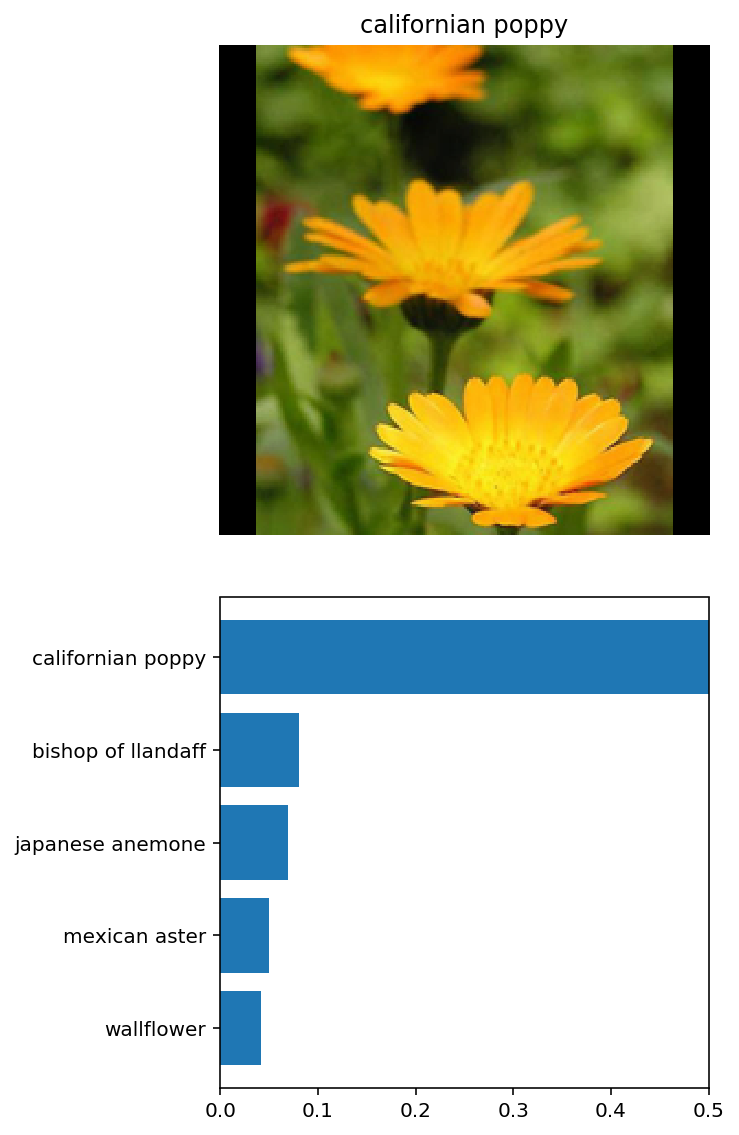

In [15]:
image_path = 'flowers/test/5/image_05169.jpg'
probs, classes = predict(image_path, model, 5, True)
fig, (ax1, ax2) = plt.subplots(figsize=(16, 8), nrows=2)

image = process_image(image_path)
image = image.numpy().transpose((1, 2, 0))

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean
image = np.clip(image, 0, 1)
ax1.axis('off')
top_class = classes[np.argmax(probs)]
ax1.set_title(cat_to_name[top_class])
ax1.imshow(image)
labels = [cat_to_name[cat] for cat in classes]
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(labels)
ax2.set_xlim(0, 0.5)
ax2.invert_yaxis() 
ax2.barh(y_pos, probs)
ax2.set_aspect(0.095)
plt.tight_layout()
print(probs)
print(classes)